# CZ4042 Assignment 2 : Part A : Object Recognition

In [1]:
import csv
import os
import pickle
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [2]:
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [13]:
# load data from file
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']
    
    # normalization
    data = np.array(data, dtype=np.float32) / 255
    
    # reshape x_train and x_test into (32,32,3) before using as input for model
    R = data[:,0:1024].reshape(-1,32,32) 
    G = data[:,1024:2048].reshape(-1,32,32) 
    B = data[:,2048:].reshape(-1,32,32)
    data = np.stack((R,G,B),axis=3) 
    
    labels = np.array(labels, dtype=np.int32)
    
    return data, labels

In [14]:
def load_pickle(filepath):
    with open(filepath, 'rb') as f:
        item = pickle.load(f)
    return item

In [40]:
# model builder for part A
def build_model(filter1, filter2, momentum, optimizer, dropout):
    # fixed parameter
    learning_rate = 0.001
    
    # model
    model = tf.keras.Sequential()
    
    model.add(layers.Input(shape=(32,32,3)))
    
    model.add(layers.Conv2D(filters=filter1, kernel_size=9, activation='relu', padding='valid', input_shape=(None, None, 3)))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2,padding="valid"))
    
    model.add(layers.Conv2D(filters=filter2, kernel_size=5, activation='relu', padding='valid'))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2,padding="valid"))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units=300, activation=None))
    if dropout:
        model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(units=10, input_shape=(300,)))  # Here no softmax because we have combined it with the loss
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    if optimizer =='SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer == 'RMSProp':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [16]:
# main training code for part A
def train(build_fn, save_file):
    
    # fixed hyperparameters for training
    epochs = 1000
    batch_size = 128
    learning_rate = 0.001

    model = build_fn()
    
    # load data
    x_train, y_train = load_data('data_batch_1')
    x_test, y_test = load_data('test_batch_trim')
    print(f"x shape {x_train.shape}")
    print(f"y shape {y_train.shape}")
    
    # model training
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test))
    
    # save model
    with open(save_file + '.pickle', 'wb') as f:
        pickle.dump(history.history, f)
    model.save(save_file + '.model' )
    
    return model, history.history

## Question 1 : Train model

In [7]:
build_model_q1 = partial(build_model, filter1=50, filter2=60, momentum=0, optimizer='SGD', dropout=False)

In [8]:
build_model_q1().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 50)        12200     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 60)          75060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 60)          0         
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               288300    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

In [11]:
model, history = train(build_model_q1, 'partA_q1')

x shape (10000, 32, 32, 3)
y shape (10000,)
Train on 10000 samples, validate on 2000 samples
Epoch 1/1000
10000/10000 [==============================] - 2s 240us/sample - loss: 2.3053 - accuracy: 0.1017 - val_loss: 2.2983 - val_accuracy: 0.1105
Epoch 2/1000
10000/10000 [==============================] - 1s 51us/sample - loss: 2.2939 - accuracy: 0.1201 - val_loss: 2.2905 - val_accuracy: 0.1175
Epoch 3/1000
10000/10000 [==============================] - 1s 52us/sample - loss: 2.2874 - accuracy: 0.1186 - val_loss: 2.2843 - val_accuracy: 0.1170
Epoch 4/1000
10000/10000 [==============================] - 1s 53us/sample - loss: 2.2813 - accuracy: 0.1264 - val_loss: 2.2778 - val_accuracy: 0.1315
Epoch 5/1000
10000/10000 [==============================] - 0s 48us/sample - loss: 2.2743 - accuracy: 0.1391 - val_loss: 2.2700 - val_accuracy: 0.1495
Epoch 6/1000
10000/10000 [==============================] - 0s 49us/sample - loss: 2.2662 - accuracy: 0.1524 - val_loss: 2.2614 - val_accuracy: 0.1640


## Question 1a : Plot losses and accuracies

In [17]:
# plot the training cost and test cost against the learning epochs
def plot_loss(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    
    # prep figure
    plt.figure(figsize=(20,5))
    plt.grid()
    
    # add data points
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Test')
    
    # labels
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
# plot the training accuracies and test accuracies against the learning epochs
def plot_accuracies(history):
    train_acc = history['accuracy']
    test_acc = history['val_accuracy']
    
    # prep figure
    plt.figure(figsize=(20,5))
    plt.grid()
    
    # add data points
    plt.plot(train_acc, label='Train')
    plt.plot(test_acc, label='Test')
    
    # labels
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

def plot_graphs(history):
    plot_loss(history)
    plot_accuracies(history)

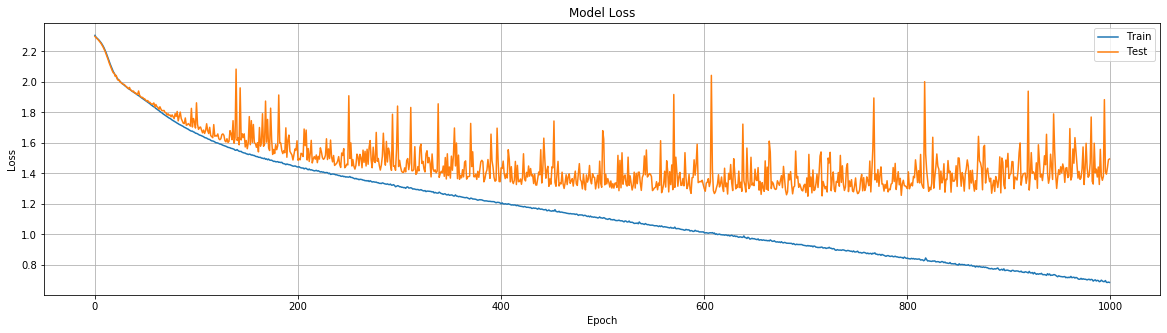

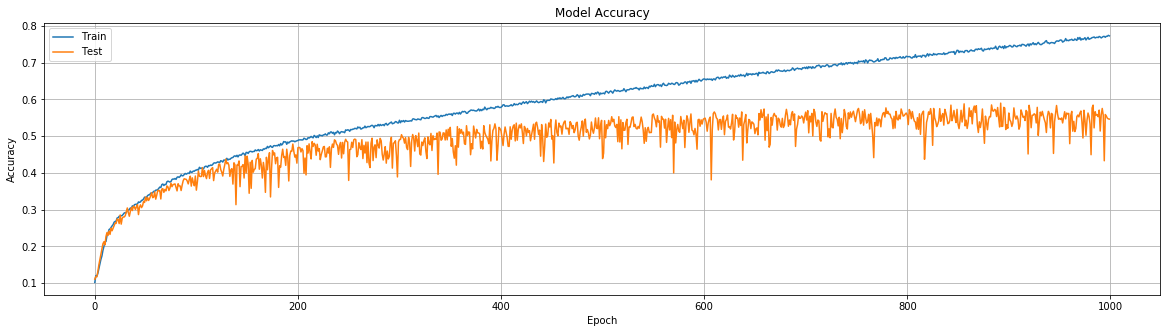

In [27]:
plot_graphs(history)

## Question 1b : Plot feature maps

In [71]:
def plot_feature_map(model, img_tensor):

    layer_outputs = [layer.output for layer in model.layers[:4]] # Extracts the outputs of the top 4 layers
    activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
    activations = activation_model.predict(np.expand_dims(img_tensor,0)) # Returns a list of five Numpy arrays: one array per layer activation
    
    layer_names = [layer.name for layer in model.layers[:4]]
        
    images_per_row = 10

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [72]:
labels = {0:'airplane',1:'automobile', 2:'bird',3:'cat',4:'deer', 5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
def plot_img(img, title): 
    fig = plt.figure(figsize=(3,3))
    
    ax = fig.add_subplot(111) 
    ax.imshow(img, interpolation='bicubic') 
    ax.set_title('Category = '+ title,fontsize =15) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


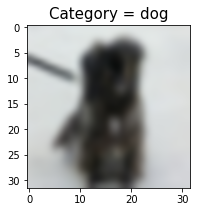

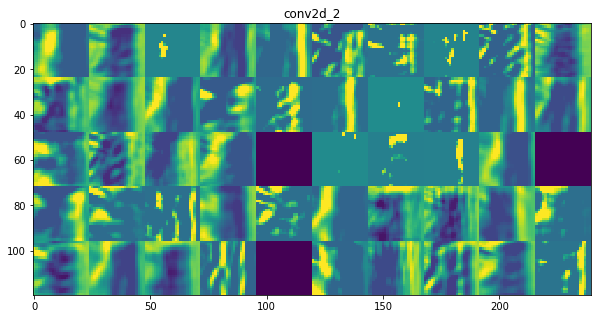

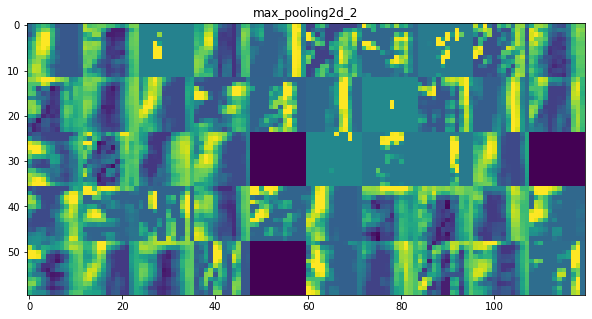

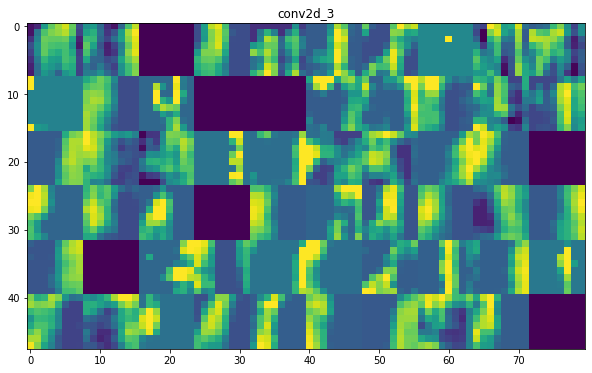

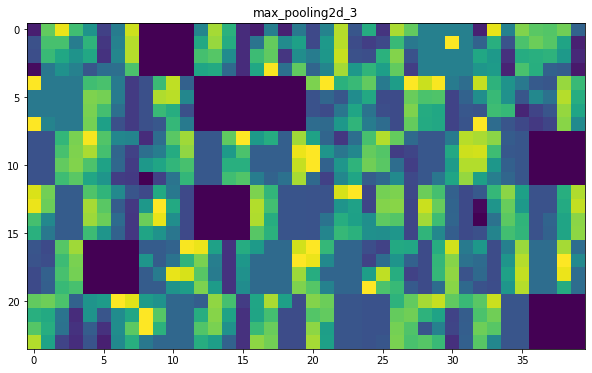

In [73]:
x_test, y_test = load_data('test_batch_trim')
plot_img(x_test[0], labels[y_test[0]])
plot_feature_map(model, x_test[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


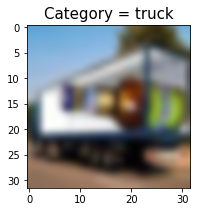

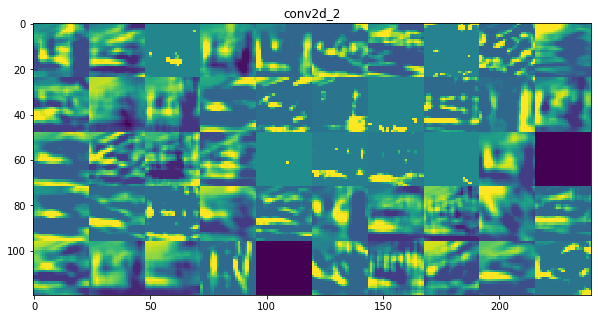

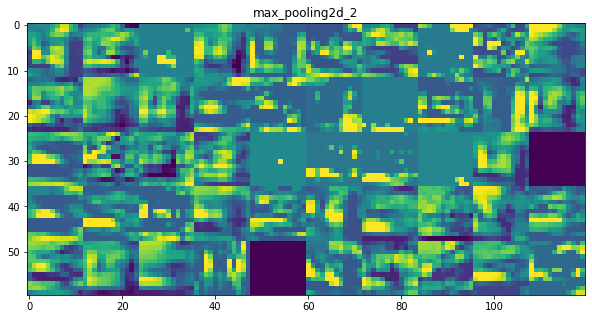

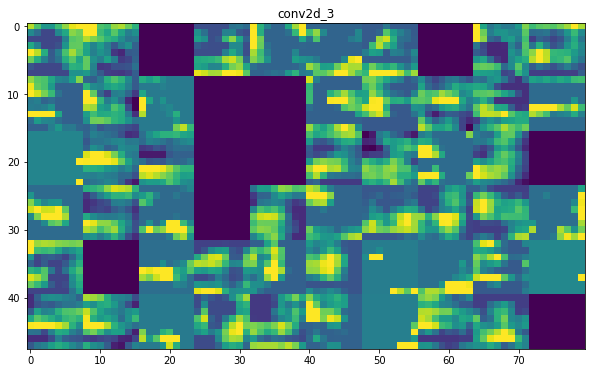

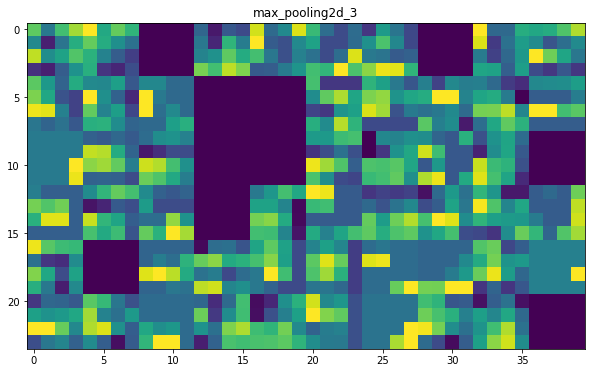

In [74]:
x_test, y_test = load_data('test_batch_trim')
plot_img(x_test[1], labels[y_test[1]])
plot_feature_map(model, x_test[1])

## Question 2 : Grid search

In [76]:
def grid_search_q2():
    filter1 = [10, 30, 50, 70, 90]
    filter2 = [20, 40, 60, 80, 100]

    # load data
    x_train, y_train = load_data('data_batch_1')
    x_test, y_test = load_data('test_batch_trim')
    build_fn = partial(build_model, momentum=0, optimizer='SGD', dropout=False)
    
    # grid search
    for f1 in filter1:
        for f2 in filter2:
            print(f'running model with filter1: {f1}, filter2: {f2}')
            build_fn = partial(build_model, filter1=f1, filter2=f2, momentum=0, optimizer='SGD', dropout=False)
            model, history = train(build_fn, f'partA_q2_{f1}_{f2}')
            with open('grid_search.csv', 'a') as f:
                writer = csv.writer(f)
                writer.writerow([f1, f2, history['accuracy'][-1], history['val_accuracy'][-1]])

In [ ]:
grid_search_q2()

running model with filter1: 10, filter2: 20
x shape (10000, 32, 32, 3)
y shape (10000,)
Train on 10000 samples, validate on 2000 samples
Epoch 1/1000
10000/10000 [==============================] - 1s 81us/sample - loss: 2.3159 - accuracy: 0.0918 - val_loss: 2.3048 - val_accuracy: 0.0995
Epoch 2/1000
10000/10000 [==============================] - 0s 36us/sample - loss: 2.3029 - accuracy: 0.1011 - val_loss: 2.2975 - val_accuracy: 0.1040
Epoch 3/1000
10000/10000 [==============================] - 0s 37us/sample - loss: 2.2968 - accuracy: 0.1024 - val_loss: 2.2929 - val_accuracy: 0.1065
Epoch 4/1000
10000/10000 [==============================] - 0s 35us/sample - loss: 2.2923 - accuracy: 0.1074 - val_loss: 2.2887 - val_accuracy: 0.1055
Epoch 5/1000
10000/10000 [==============================] - 0s 37us/sample - loss: 2.2880 - accuracy: 0.1123 - val_loss: 2.2842 - val_accuracy: 0.1155
Epoch 6/1000
10000/10000 [==============================] - 0s 36us/sample - loss: 2.2832 - accuracy: 0.1220

In [11]:
def show_csv_results():
    with open('grid_search.csv', 'r') as f:
        lines = csv.reader(f)
        best = max(lines, key= lambda x: x[-1])
        
    print(f"Optimal parameters, filter1: {best[0]}, filter2: {best[1]}")
    
    
show_csv_results()

Optimal parameters, filter1: 30, filter2: 60


## Question 3

In [12]:
OPTIMAL_FILTER1 = 30
OPTIMAL_FILTER2 = 60

### Adding momentum y=0.1

In [18]:
build_fn = partial(build_model, filter1=OPTIMAL_FILTER1, filter2=OPTIMAL_FILTER2, momentum=0.1, optimizer='SGD', dropout=False)
build_fn().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 30)        7320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 60)          45060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 60)          0         
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               288300    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

In [19]:
_ , history = train(build_fn, 'partA_q3_momentum')

x shape (10000, 32, 32, 3)
y shape (10000,)
Train on 10000 samples, validate on 2000 samples
Epoch 1/1000
10000/10000 [==============================] - 3s 267us/sample - loss: 2.3098 - accuracy: 0.0957 - val_loss: 2.3017 - val_accuracy: 0.0845
Epoch 2/1000
10000/10000 [==============================] - 1s 56us/sample - loss: 2.2954 - accuracy: 0.1073 - val_loss: 2.2935 - val_accuracy: 0.1075
Epoch 3/1000
10000/10000 [==============================] - 1s 54us/sample - loss: 2.2884 - accuracy: 0.1131 - val_loss: 2.2871 - val_accuracy: 0.1090
Epoch 4/1000
10000/10000 [==============================] - 1s 56us/sample - loss: 2.2818 - accuracy: 0.1196 - val_loss: 2.2805 - val_accuracy: 0.1230
Epoch 5/1000
10000/10000 [==============================] - 1s 52us/sample - loss: 2.2752 - accuracy: 0.1303 - val_loss: 2.2735 - val_accuracy: 0.1390
Epoch 6/1000
10000/10000 [==============================] - 1s 58us/sample - loss: 2.2681 - accuracy: 0.1378 - val_loss: 2.2660 - val_accuracy: 0.1530


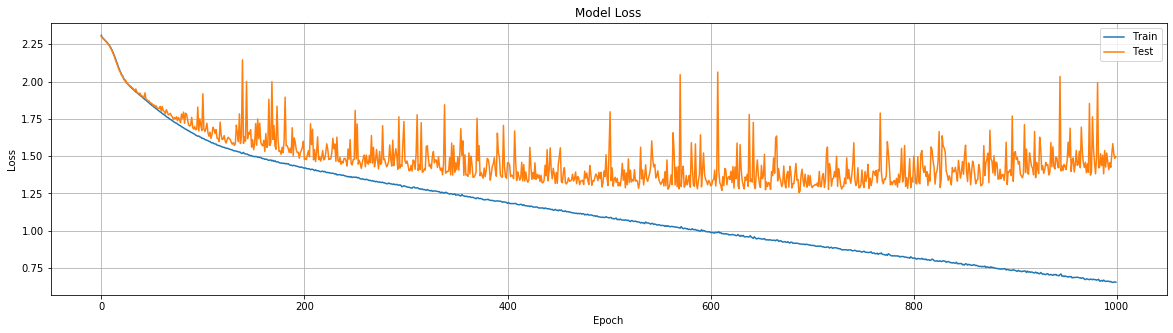

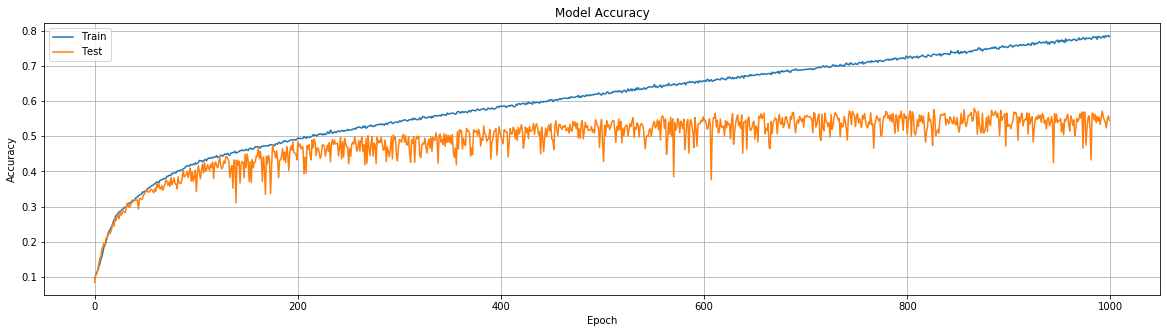

In [20]:
plot_graphs(history)

### Using RMSProp optimizer

In [33]:
build_fn = partial(build_model, filter1=OPTIMAL_FILTER1, filter2=OPTIMAL_FILTER2, momentum=0, optimizer='RMSProp', dropout=False)
build_fn().summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 24, 24, 30)        7320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 60)          45060     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 4, 4, 60)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 300)               288300    
_________________________________________________________________
dense_21 (Dense)             (None, 10)              

In [34]:
_ , history = train(build_fn, 'partA_q3_rmsprop')

x shape (10000, 32, 32, 3)
y shape (10000,)
Train on 10000 samples, validate on 2000 samples
Epoch 1/1000
10000/10000 [==============================] - 1s 133us/sample - loss: 2.2359 - accuracy: 0.1997 - val_loss: 2.4345 - val_accuracy: 0.2005
Epoch 2/1000
10000/10000 [==============================] - 0s 48us/sample - loss: 1.9457 - accuracy: 0.3069 - val_loss: 1.8881 - val_accuracy: 0.2810
Epoch 3/1000
10000/10000 [==============================] - 1s 55us/sample - loss: 1.7611 - accuracy: 0.3695 - val_loss: 2.0351 - val_accuracy: 0.2875
Epoch 4/1000
10000/10000 [==============================] - 1s 58us/sample - loss: 1.6571 - accuracy: 0.4084 - val_loss: 1.7693 - val_accuracy: 0.3775
Epoch 5/1000
10000/10000 [==============================] - 1s 58us/sample - loss: 1.5676 - accuracy: 0.4411 - val_loss: 1.8142 - val_accuracy: 0.3785
Epoch 6/1000
10000/10000 [==============================] - 1s 55us/sample - loss: 1.4712 - accuracy: 0.4755 - val_loss: 1.6992 - val_accuracy: 0.4035


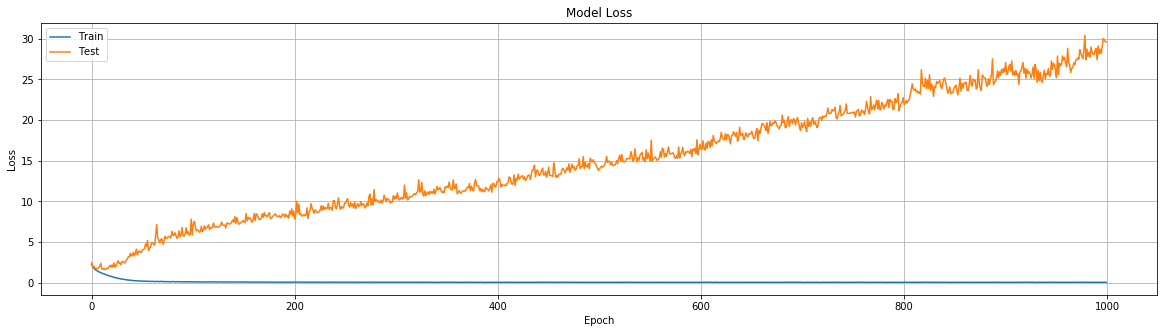

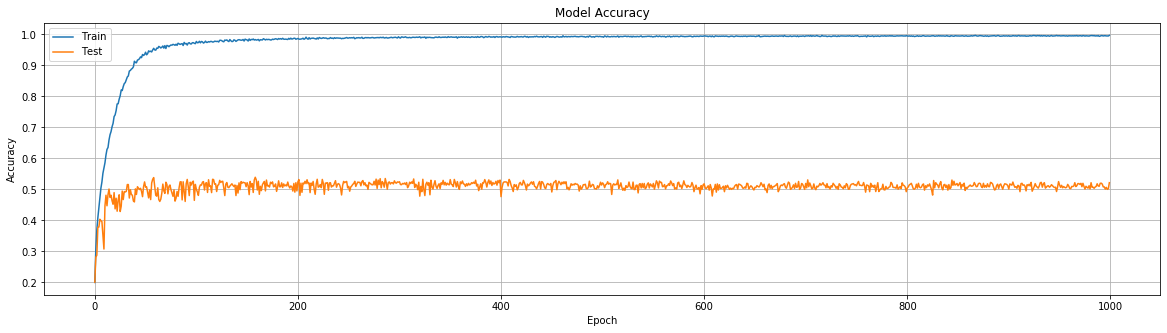

In [35]:
plot_graphs(history)

### Using Adam optimizer

In [37]:
build_fn = partial(build_model, filter1=OPTIMAL_FILTER1, filter2=OPTIMAL_FILTER2, momentum=0, optimizer='Adam', dropout=False)
build_fn().summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 24, 24, 30)        7320      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 60)          45060     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 4, 4, 60)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 300)               288300    
_________________________________________________________________
dense_25 (Dense)             (None, 10)              

In [38]:
_ , history = train(build_fn, 'partA_q3_adam')

x shape (10000, 32, 32, 3)
y shape (10000,)
Train on 10000 samples, validate on 2000 samples
Epoch 1/1000
10000/10000 [==============================] - 1s 119us/sample - loss: 1.9590 - accuracy: 0.2847 - val_loss: 1.7277 - val_accuracy: 0.3715
Epoch 2/1000
10000/10000 [==============================] - 1s 56us/sample - loss: 1.6319 - accuracy: 0.4088 - val_loss: 1.7274 - val_accuracy: 0.4025
Epoch 3/1000
10000/10000 [==============================] - 1s 56us/sample - loss: 1.5214 - accuracy: 0.4519 - val_loss: 1.5208 - val_accuracy: 0.4500
Epoch 4/1000
10000/10000 [==============================] - 0s 48us/sample - loss: 1.3999 - accuracy: 0.4990 - val_loss: 1.4213 - val_accuracy: 0.4915
Epoch 5/1000
10000/10000 [==============================] - 1s 56us/sample - loss: 1.3333 - accuracy: 0.5269 - val_loss: 1.4508 - val_accuracy: 0.4835
Epoch 6/1000
10000/10000 [==============================] - 1s 53us/sample - loss: 1.2746 - accuracy: 0.5458 - val_loss: 1.3942 - val_accuracy: 0.5235


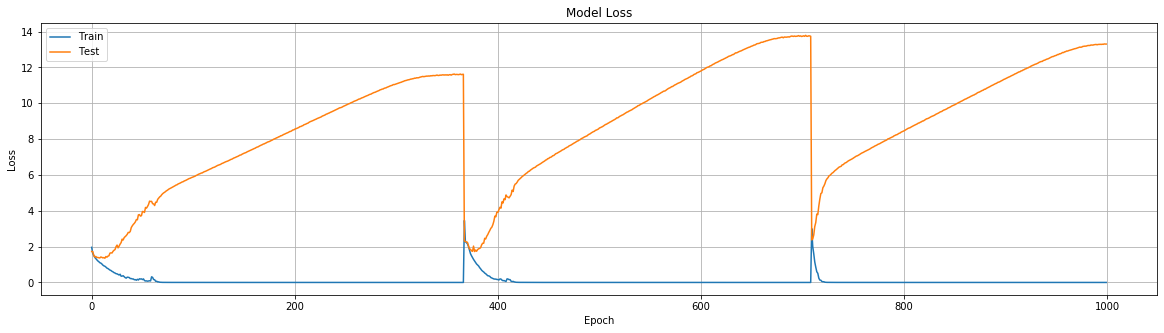

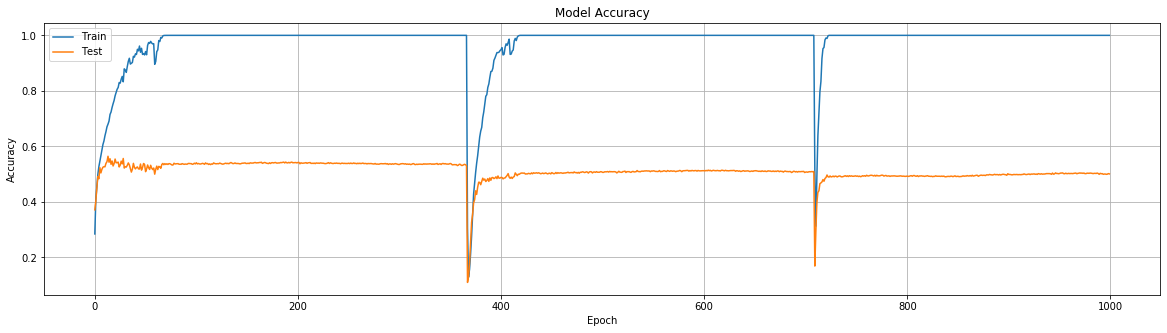

In [39]:
plot_graphs(history)

### Adding dropout

In [30]:
build_fn = partial(build_model, filter1=OPTIMAL_FILTER1, filter2=OPTIMAL_FILTER2, momentum=0, optimizer='SGD', dropout=True)
build_fn().summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 24, 24, 30)        7320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 60)          45060     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 60)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 300)               288300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)              

In [31]:
_ , history = train(build_fn, 'partA_q3_dropout')

x shape (10000, 32, 32, 3)
y shape (10000,)
Train on 10000 samples, validate on 2000 samples
Epoch 1/1000
10000/10000 [==============================] - 1s 113us/sample - loss: 2.3154 - accuracy: 0.1117 - val_loss: 2.2899 - val_accuracy: 0.1525
Epoch 2/1000
10000/10000 [==============================] - 1s 56us/sample - loss: 2.2970 - accuracy: 0.1200 - val_loss: 2.2818 - val_accuracy: 0.1610
Epoch 3/1000
10000/10000 [==============================] - 1s 59us/sample - loss: 2.2888 - accuracy: 0.1313 - val_loss: 2.2760 - val_accuracy: 0.1685
Epoch 4/1000
10000/10000 [==============================] - 1s 57us/sample - loss: 2.2815 - accuracy: 0.1331 - val_loss: 2.2694 - val_accuracy: 0.1890
Epoch 5/1000
10000/10000 [==============================] - 1s 58us/sample - loss: 2.2754 - accuracy: 0.1454 - val_loss: 2.2627 - val_accuracy: 0.1795
Epoch 6/1000
10000/10000 [==============================] - 1s 59us/sample - loss: 2.2656 - accuracy: 0.1517 - val_loss: 2.2549 - val_accuracy: 0.1895


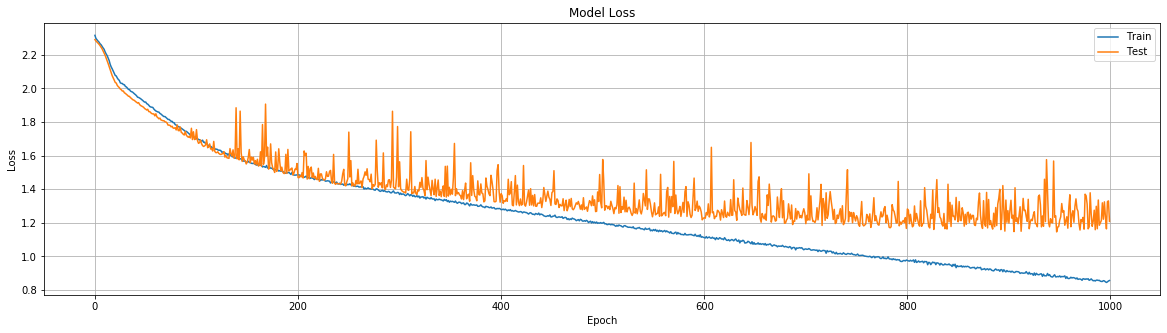

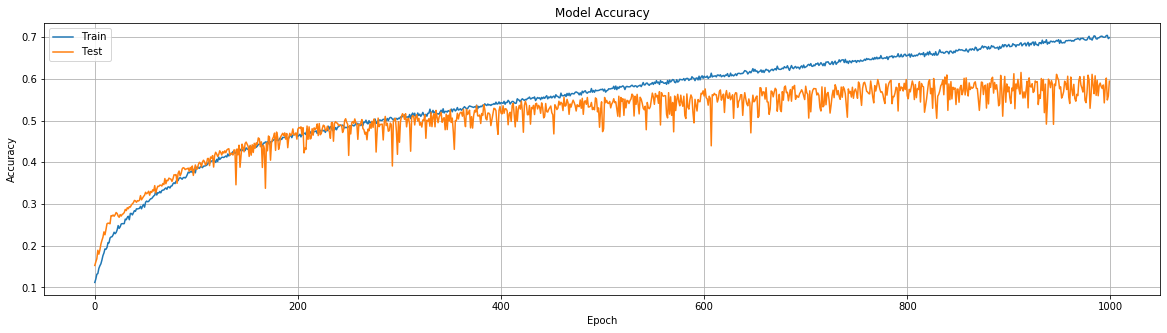

In [32]:
plot_graphs(history)